Guillaume FAURE et Garance LUCAS

# Exercice 1 - Construction de règles contre-factuelles

1. Ensembles de données

In [1]:
import random

import sklearn
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_text
import pandas as pd
import numpy as np
import random
import copy as cp
from tqdm import tqdm

In [2]:
iris = load_iris()  
X,Y = iris.data, iris.target
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)

2. Arbre de décision

In [3]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
arbre = clf.tree_

Classe prédite:  [0 1 2 2 2 0 0 1 1 1 0 2 0 2 2 1 2 2 0 1 1 0 1 0 0 1 2 2 1 0]
Accuracy test:  0.9333333333333333


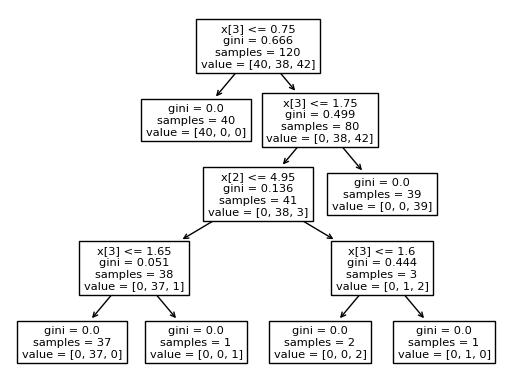

In [4]:
tree.plot_tree(clf)
y_pred = clf.predict(X_test)
print('Classe prédite: ', y_pred)
accuracy = clf.score(X_test, y_test)
print('Accuracy test: ', accuracy)

path = clf.decision_path(X_test)

3. Choix exemple

In [5]:
def analyser_exemple(clf, x, feature_names):

    # On reshape l'exemple pour pouvoir l'utiliser dans la fonction predict
    x_reshape = np.array(x).reshape(1, -1)
    y_pred = clf.predict(x_reshape)
    print('Classe prédite: ', y_pred)

    # On récupère la feuille dans laquelle l'exemple est classé
    leaf = clf.apply(x_reshape)
    print('Feuille: ', leaf)

    # On récupère le chemin dans l'arbre pour l'exemple
    path = clf.decision_path(x_reshape)
    print("Chemin dans l'arbre: ")
    print(path)

    node_indices = path.indices

    # Règles pour chaque nœud dans le chemin pour x
    rules_x = []
    for node_index in node_indices:
        node = clf.tree_.value[node_index]
        feature_index = clf.tree_.feature[node_index]
        threshold = clf.tree_.threshold[node_index]

        if feature_index != -2:  # -2 signifie un nœud feuille
            rules_x.append(f"{feature_names[feature_index]} <= {threshold}")
            if node[0][0] > node[0][1]:
                class_label = "Classe 0"
            else:
                class_label = "Classe 1"

            print(f"Nœud {node_index}: Si la caractéristique {feature_names[feature_index]} <= {threshold}, alors {class_label}")
    
    print("Règles pour x: ", rules_x)
    return rules_x

In [6]:
x = X_test[1]
print('Exemple: ', x)

node_indices = path.indices
feature_names = iris.feature_names

# Exemple d'utilisation de la fonction
rules_x = analyser_exemple(clf, x, iris.feature_names)

Exemple:  [6.  2.9 4.5 1.5]
Classe prédite:  [1]
Feuille:  [5]
Chemin dans l'arbre: 
  (0, 0)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
Nœud 0: Si la caractéristique petal width (cm) <= 0.75, alors Classe 0
Nœud 2: Si la caractéristique petal width (cm) <= 1.75, alors Classe 1
Nœud 3: Si la caractéristique petal length (cm) <= 4.950000047683716, alors Classe 1
Nœud 4: Si la caractéristique petal width (cm) <= 1.6500000357627869, alors Classe 1
Règles pour x:  ['petal width (cm) <= 0.75', 'petal width (cm) <= 1.75', 'petal length (cm) <= 4.950000047683716', 'petal width (cm) <= 1.6500000357627869']


4. Règle contre-factuelles

In [7]:
from sklearn.tree import _tree

def find_paths(tree, node_id, current_path, x_class, leaf_paths):
    """
    Récursivement trouver tous les chemins d'un nœud donné vers les feuilles
    qui ont une classe différente de x_class.
    """
    # Si c'est une feuille
    if tree.children_left[node_id] == _tree.TREE_LEAF:
        # Si la classe de la feuille est différente de x_class
        if tree.value[node_id].argmax() != x_class:
            # Ajouter le chemin à la liste
            leaf_paths.append((current_path, tree.value[node_id].argmax()))
        return

    # Si c'est un nœud interne, appeler récursivement sur les enfants
    if tree.children_left[node_id] != _tree.TREE_LEAF:
        find_paths(tree, tree.children_left[node_id], current_path + [(node_id, 'left')], x_class, leaf_paths)
    if tree.children_right[node_id] != _tree.TREE_LEAF:
        find_paths(tree, tree.children_right[node_id], current_path + [(node_id, 'right')], x_class, leaf_paths)


def get_leaf_paths_for_different_class(clf, x, feature_names):
    """
    Obtenir tous les chemins de l'arbre clf qui mènent à des feuilles
    dont la classe prédite est différente de celle prédite pour l'exemple x.
    """
    # Prédire la classe pour l'exemple x
    x_class = clf.predict([x])[0]

    # Initialiser la liste pour stocker les chemins
    leaf_paths = []
    find_paths(clf.tree_, 0, [], x_class, leaf_paths)

    # Traduire les chemins en règles
    paths_with_rules = []
    for path, class_idx in leaf_paths:
        rules = []
        for node_id, direction in path:
            if direction == 'left':
                threshold = clf.tree_.threshold[node_id]
                feature = feature_names[clf.tree_.feature[node_id]]
                rules.append(f"{feature} <= {threshold}")
            else:
                threshold = clf.tree_.threshold[node_id]
                feature = feature_names[clf.tree_.feature[node_id]]
                rules.append(f"{feature} > {threshold}")
        paths_with_rules.append((rules, clf.classes_[class_idx]))

    return paths_with_rules

# Appliquer la fonction à notre exemple x
paths = get_leaf_paths_for_different_class(clf, x, feature_names)

In [8]:
count_chemin = []

for path,_ in paths:
    count = 0
    for rules in rules_x:
        if rules in path:
            count += 1
    count_chemin.append(count)
    
    
i = 0
for rules, class_name in paths:
    print(f"Rules: {rules} \n => Class: {iris.target_names[class_name]} \n {count_chemin[i]} noeuds en commun avec le chemin de x")
    print('')
    i += 1 

Rules: ['petal width (cm) <= 0.75'] 
 => Class: setosa 
 1 noeuds en commun avec le chemin de x

Rules: ['petal width (cm) > 0.75', 'petal width (cm) <= 1.75', 'petal length (cm) <= 4.950000047683716', 'petal width (cm) > 1.6500000357627869'] 
 => Class: virginica 
 2 noeuds en commun avec le chemin de x

Rules: ['petal width (cm) > 0.75', 'petal width (cm) <= 1.75', 'petal length (cm) > 4.950000047683716', 'petal width (cm) <= 1.600000023841858'] 
 => Class: virginica 
 1 noeuds en commun avec le chemin de x

Rules: ['petal width (cm) > 0.75', 'petal width (cm) > 1.75'] 
 => Class: virginica 
 0 noeuds en commun avec le chemin de x


5. Explication pour la classification d'un exemple

In [9]:
explication = np.argmax(count_chemin)
path_explication = paths[explication][0]

differences = [(i, a, b) for i, (a, b) in enumerate(zip(path_explication, rules_x)) if a != b]

# Afficher les différences
for _, val1, val2 in differences:
    print(f"valeurs différentes: \n {val1}")
    print('')

valeurs différentes: 
 petal width (cm) > 0.75

valeurs différentes: 
 petal width (cm) > 1.6500000357627869


6.  Explication pour classification de x par l'arbre de decision

Si la fleur avait une largeur de pétal strictement supérieure à 0.80 et que la longueur de la pétal était inférieure ou égale a 5.35, alors elle aurait été classée dans la classe versicolor.

Nous avons choisit de prendre l'argmax du nombre de chemins parmi les contre-factuels de x. 

# Exercice 2 - Generalisation de bases d'apprentissage et d'explications

1. Génération d'une base d'apprentissage pour construire un modele de substitution

In [10]:
def generate_base(x, black_box, N, G, pc, pm, size_sub_pop, Z_equal, liste_min_max):
    
    def euclidean_distance(x,z):
        return np.sqrt(np.sum((x-z)**2))
    
    
    def fitness(Z_equal, black_box, x, z, distance = euclidean_distance):
        x = np.array(x['attributs']).reshape(1, -1)
        z = np.array(z['attributs']).reshape(1, -1)
        pred_x = black_box.predict(x)
        pred_z = black_box.predict(z)
        
        if Z_equal:
            if pred_x == pred_z:
                I1 = 1
            else:
                I1 = 0
        
        # Nous avons modifié la pondération pour la fitness afin de favoriser l'appartenance a une classe differente de f(x)      
        else:
            if pred_x != pred_z:
                I1 = 2
            else:
                I1 = -1

        return I1*2 + (1-distance(x, z)) - (x == z).all()                
    
    def evaluate(population, x, black_box, Z_equal, distance = euclidean_distance):
        for i in range(len(population)):
            population[i]['fitness'] = fitness(Z_equal, black_box, x, population[i], distance)
        return population
    
    
    def select(population, size_sub_pop):
        selected_population = sorted(population, key=lambda x: x['fitness'], reverse=True)[:size_sub_pop]
    
        return selected_population
    
    
    def crossover(population, pc):
        new_population = []
        ens_caracteristiques_indices = [i for i in range(len(population[0]))]
        
        # On applique un crossover a pc% de la population
        for _ in range(int(len(population)*pc)):
            # Selectionner deux parents aleatoirement
            parent1 = np.random.choice(population)
            parent2 = np.random.choice(population)
            
            # Selectionner deux caracteristiques aleatoirement
            caracteristique1 = np.random.choice(ens_caracteristiques_indices)
            caracteristique2 = np.random.choice(ens_caracteristiques_indices)
            while caracteristique1 == caracteristique2:
                caracteristique2 = np.random.choice(ens_caracteristiques_indices)
                
            # Composer les deux enfants issus du crossover
            child1 = cp.deepcopy(parent1)
            child2 = cp.deepcopy(parent2)
            child1['attributs'][caracteristique1] = parent2['attributs'][caracteristique1]
            child2['attributs'][caracteristique2] = parent1['attributs'][caracteristique2]
            new_population.append(child1)
            new_population.append(child2)
        
        return new_population+population
    
    
    def mutate(population, pm, liste_min_max):
        mutated_population = []
        population_copy = cp.deepcopy(population)
        ens_caracteristiques_indices = [i for i in range(len(population[0]))]
        
        # On applique une mutation a pm% de la population
        for _ in range(int(len(population)*pm)):
            # Selectionner un individu aleatoirement
            ind = np.random.choice(population_copy)
            
            # Selectionner une caracteristique aleatoirement
            caracteristique_indice = np.random.choice(ens_caracteristiques_indices)
            
           # Recuperer les bornes de la caracteristique
            min_caracteristique = liste_min_max[caracteristique_indice][0]
            max_caracteristique = liste_min_max[caracteristique_indice][1]

            # Muter l'individu
            ind['attributs'][caracteristique_indice] = np.random.uniform(min_caracteristique, max_caracteristique)
            mutated_population.append(ind)
    
        return mutated_population+population

    
    # Initialize population
    P = [x for _ in range(N)]
    [evaluate(P, x, black_box, Z_equal) for x in P]

    # Main loop
    for i in tqdm(range(G)):
        # Selection
        A = select(P, size_sub_pop)

        # Crossover
        B = crossover(A, pc)

        # Mutation
        C = mutate(B, pm, liste_min_max)

        # Evaluation
        [evaluate(C, x, black_box, Z_equal) for x in C]

        # Update population
        P = C

    Z = P
    return Z

In [ ]:
x = X_test[2]
print('Exemple: ', x)
x_reshape = np.array(x).reshape(1, -1)
print('x_reshape: ', x_reshape)
y_pred = clf.predict(x_reshape)
print('Classe prédite: ', y_pred)

x = {'attributs': x, 'fitness': 0}
print(x)

liste_min_max = [(X_train[:,i].min(), X_train[:,i].max()) for i in range(len(X_train[0]))]
print('list min max: ',liste_min_max)


Z_equal = generate_base(x, clf, N=100, G=100, pc=0.9, pm=0.9, size_sub_pop=20, Z_equal=True, liste_min_max=liste_min_max)

Z_diff = generate_base(x, clf, N=100, G=300, pc=0.9, pm=0.9, size_sub_pop=20, Z_equal=False, liste_min_max=liste_min_max)

print('Z equal: ', Z_equal)
print('Z diff: ', Z_diff)

Exemple:  [7.7 3.8 6.7 2.2]
x_reshape:  [[7.7 3.8 6.7 2.2]]
Classe prédite:  [2]
{'attributs': array([7.7, 3.8, 6.7, 2.2]), 'fitness': 0}
list min max:  [(4.3, 7.9), (2.0, 4.4), (1.0, 6.9), (0.1, 2.5)]


 72%|███████▏  | 72/100 [00:58<00:22,  1.24it/s]

In [ ]:
print(clf.predict(x_reshape))
print([clf.predict(Z_equal[j]['attributs'].reshape(1, -1)) for j in range(len(Z_equal))])
print([clf.predict(Z_diff[i]['attributs'].reshape(1, -1)) for i in range(len(Z_diff))])

2. Generation d'applications de la classification 

Accuracy:  1.0


[Text(0.5, 0.5, 'gini = 0.0\nsamples = 212\nvalue = 212.0')]

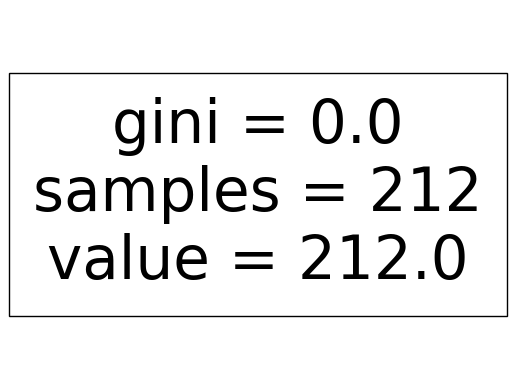

In [19]:
Z = Z_equal + Z_diff
Z = np.array([Z[i]['attributs'].reshape(1, -1) for i in range(len(Z))]).reshape(-1, 4)
true_Z = clf.predict(Z)

clf2 = DecisionTreeClassifier()
clf2.fit(Z, true_Z)
accuracy = clf2.score(Z, true_Z)
print('Accuracy: ', accuracy)

tree.plot_tree(clf2)

In [20]:
# Avec un exemple

pred_x = clf.predict(x_reshape)
eplained_x = clf2.predict(x_reshape)

print('Classe prédite: ', pred_x)
print('Classe expliquée: ', eplained_x)

Classe prédite:  [1]
Classe expliquée:  [1]


# Exercice 3 - Expérimentations

In [21]:
from sklearn.datasets import make_moons 
from sklearn.datasets import load_breast_cancer

Utilisation de la base de données Make_moons avec un bruit de 0.3 afin d'avoir des classes qui se chevauchent.

In [35]:
X, Y = make_moons(n_samples=1000, shuffle = True, noise=0.3)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)

model1 = DecisionTreeClassifier()
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print('Accuracy test: ', model1.score(X_test, y_test))

# on prend un exemple au hasard
exemple_index = random.randint(0, len(X_test))
x = X_test[exemple_index]
print('Exemple: ', x)
x_reshape = np.array(x).reshape(1, -1)
print('x_reshape: ', x_reshape)
y_pred = model1.predict(x_reshape)
print('Classe prédite: ', y_pred)

x = {'attributs': x, 'fitness': 0}
print(x)

liste_min_max = [(X_train[:,i].min(), X_train[:,i].max()) for i in range(len(X_train[0]))]
print('list min max: ',liste_min_max)


Z_equal = generate_base(x, model1, N=100, G=100, pc=0.9, pm=0.9, size_sub_pop=20, Z_equal=True, liste_min_max=liste_min_max)

Z_diff = generate_base(x, model1, N=100, G=300, pc=0.9, pm=0.9, size_sub_pop=20, Z_equal=False, liste_min_max=liste_min_max)

print('Z equal: ', Z_equal)
print('Z diff: ', Z_diff)

Accuracy test:  0.87
Exemple:  [0.6518923  0.82129112]
x_reshape:  [[0.6518923  0.82129112]]
Classe prédite:  [0]
{'attributs': array([0.6518923 , 0.82129112]), 'fitness': 0}
list min max:  [(-1.7181273021301484, 2.571287479517543), (-1.3722930561396205, 1.95491221396033)]


100%|██████████| 300/300 [04:04<00:00,  1.23it/s]

Z equal:  [{'attributs': array([-0.08982914, -1.31356884]), 'fitness': -1.396790333132409}, {'attributs': array([-0.08982914,  0.30362913]), 'fitness': 0.22040764021935266}, {'attributs': array([ 2.08664121, -0.62172757]), 'fitness': -1.7647557692275915}, {'attributs': array([1.5579422 , 0.71599359]), 'fitness': -0.688196290750615}, {'attributs': array([1.52507501, 1.08322149]), 'fitness': -0.6149041506324007}, {'attributs': array([-0.08982914, -0.67818524]), 'fitness': -0.7614067336575987}, {'attributs': array([-0.88297845,  1.18738949]), 'fitness': 2.200039500797516}, {'attributs': array([0.28691361, 0.19595148]), 'fitness': 0.03605852264086706}, {'attributs': array([-0.08982914,  1.45400493]), 'fitness': 2.6292165641069025}, {'attributs': array([2.42272372, 0.7418736 ]), 'fitness': -1.5356340953152157}, {'attributs': array([ 1.0187964 , -0.78531844]), 'fitness': -1.1726693406503252}, {'attributs': array([1.5579422 , 0.71599359]), 'fitness': -0.688196290750615}, {'attributs': array([

Accuracy:  1.0
Classe prédite:  [0]
Classe expliquée:  [0]


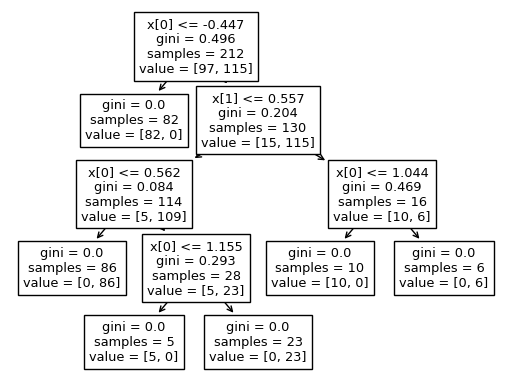

In [24]:
Z = Z_equal + Z_diff
Z = np.array([Z[i]['attributs'].reshape(1, -1) for i in range(len(Z))]).reshape(-1, 2)
true_Z = model1.predict(Z)

clf2 = DecisionTreeClassifier()
clf2.fit(Z, true_Z)
accuracy = clf2.score(Z, true_Z)
print('Accuracy: ', accuracy)

tree.plot_tree(clf2)

# Avec un exemple

pred_x = model1.predict(x_reshape)
eplained_x = clf2.predict(x_reshape)

print('Classe prédite: ', pred_x)
print('Classe expliquée: ', eplained_x)

In [30]:
import matplotlib.pyplot as plt

def affichage_list(x, X_test, y_test, classifier):
    
    # Plot the points of X except x
    plt.plot(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1],'bs')
    plt.plot(X_test[:, 0][y_test==0], X_test[:, 1][y_test==0], 'g^')

    # Plot x 
    plt.plot(x['attributs'][0], x['attributs'][1], 'ro', label = 'x')
    
    #frontière décision 
    h = .02  
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap='gray')

    # X contains two features, x1 and x2
    plt.xlabel(r"$x_0$", fontsize=20)
    plt.ylabel(r"$x_1$", fontsize=20)

    # commentaires
    plt.legend()

    # Displaying the plot.
    plt.show()

Modele de substitution: 


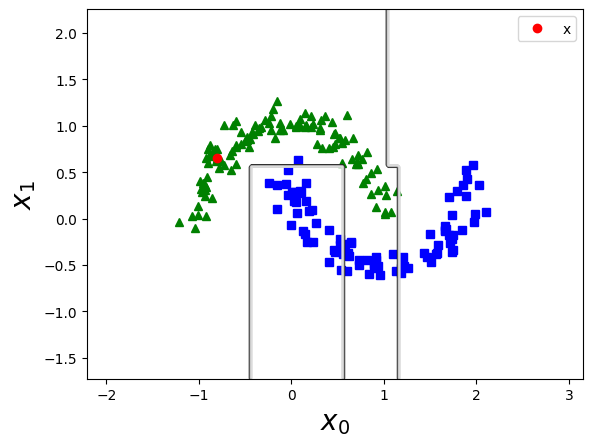

In [33]:
print('Modele de substitution: ')
affichage_list(x, X_test, y_test, clf2)

Modele a expliquer: 


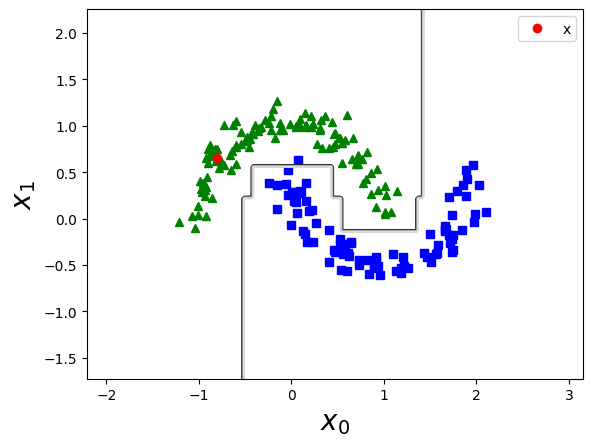

In [34]:
print('Modele a expliquer: ')
affichage_list(x, X_test, y_test, model1)

Les points generes par l'algorithme genetique etant dans un proche voisinage de x, l'accuracy du modele de substitution est de 1. En effet, bien que la frontiere de classification ne soit pas la meme que celle du modele a expliquer, cela est normal car l'explication est locale. Et elle suffit localement a bien separer les deux classes. 

On peut voir que localement a x les frontieres de decision sont assez semblables. Ainsi, nous pouvons etre confiants dans l'explication de x par le modele de substitution.

Si x0 etait plus grand que -0.5 (sans depasser 0.5) et que x1 etait inferieur a 0.5, alors x aurait appartenu a l'autre classe.

In [ ]:
X, Y = load_breast_cancer()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)

model2 = DecisionTreeClassifier()
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print('Accuracy test: ', model2.score(X_test, y_test))

# on prend un exemple au hasard
exemple_index = random.randint(0, len(X_test))
x = X_test[exemple_index]
print('Exemple: ', x)
x_reshape = np.array(x).reshape(1, -1)
print('x_reshape: ', x_reshape)
y_pred = model2.predict(x_reshape)
print('Classe prédite: ', y_pred)

x = {'attributs': x, 'fitness': 0}
print(x)

liste_min_max = [(X_train[:,i].min(), X_train[:,i].max()) for i in range(len(X_train[0]))]
print('list min max: ',liste_min_max)


Z_equal = generate_base(x, model2, N=100, G=100, pc=0.9, pm=0.9, size_sub_pop=20, Z_equal=True, liste_min_max=liste_min_max)

Z_diff = generate_base(x, model2, N=100, G=300, pc=0.9, pm=0.9, size_sub_pop=20, Z_equal=False, liste_min_max=liste_min_max)

print('Z equal: ', Z_equal)
print('Z diff: ', Z_diff)